# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import cv2
import glob
import pickle
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import tensorflow as tf

from pandas.io.parsers import read_csv
from collections import Counter
from tensorflow.contrib.layers import flatten
from skimage import transform
from skimage.util import img_as_ubyte
from sklearn.utils import shuffle


# Plot all graphical outputs inline
%matplotlib inline


# Load train, valid and testing data sets
training_file   = './data/train.p'
validation_file = './data/valid.p'
testing_file    = './data/test.p'

# Get the sign name for each classification class
signnames = read_csv("signnames.csv").values[:, 1]

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print('Data loaded')

Data loaded


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
# Number of training examples
n_train = X_train.shape[0]

# Number of training examples
n_valid = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

mean = np.mean(X_train)
std = np.std(X_train)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("Mean of training data =", mean)
print("Standard deviation of training data =", std)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Mean of training data = 82.677589037
Standard deviation of training data = 67.8508884263


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

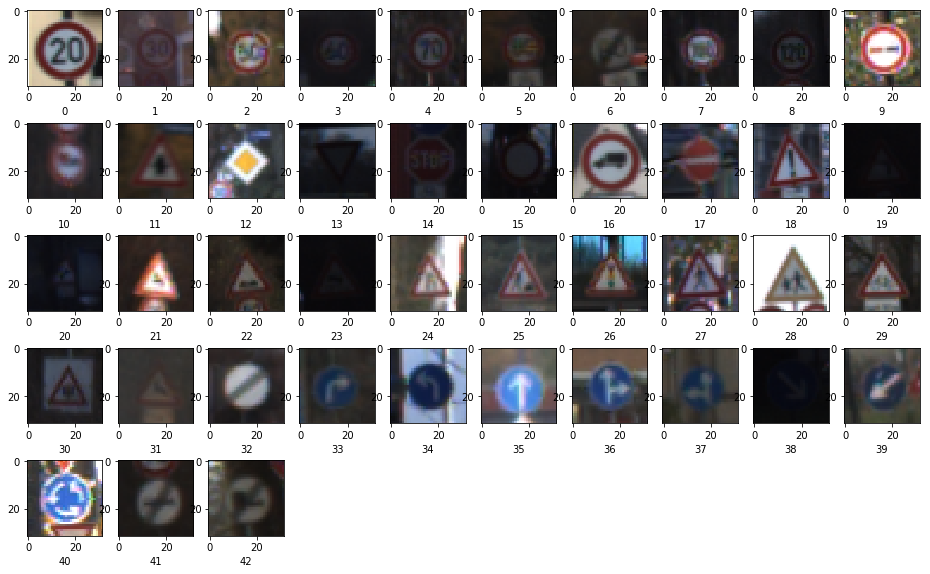

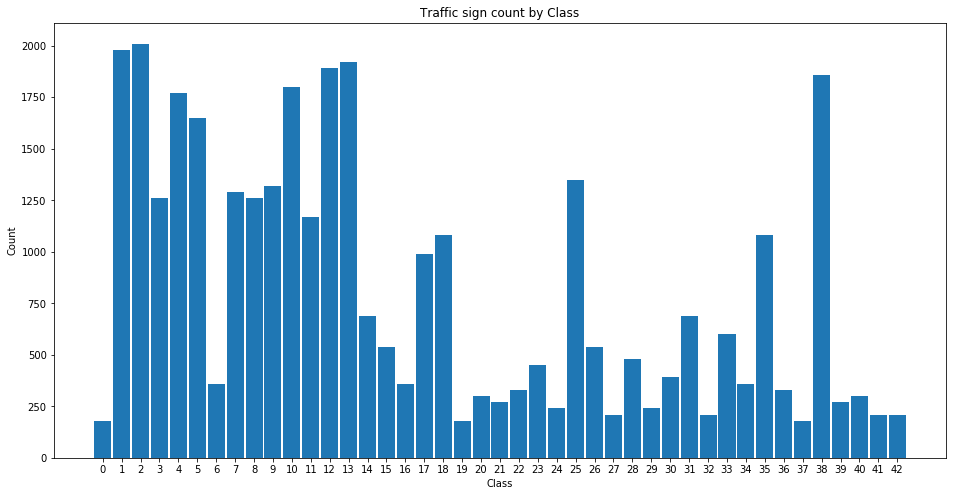

In [3]:
# Visualize each traffic sign ones
signs = []
printed = []
for index, val in enumerate(y_train):
    if val not in printed:
        printed.append(val)
        signs.append((val, index))
        
signs.sort(key=lambda tup: tup[0])

fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(10)

for index, sign in enumerate(signs):
    ax = fig.add_subplot(5, 10, index + 1)
    ax.set_xlabel(sign[0])
    ax.imshow(X_train[sign[1]].squeeze())

    
# Count the occurance of each individual label
labels, count_signs_by_class = zip(*Counter(y_train).items())
indexes = np.arange(len(labels))

# Show bar chart 
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(indexes, count_signs_by_class, width=0.9, align='center')
ax.set_title('Traffic sign count by Class')
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.set_xticks(indexes)
ax.set_xticklabels(labels)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [4]:
# Define utility functions
def center_normalize(data, mean, std):
    """Center normalize images"""
    data = data.astype('float32')
    data = (data / 255) - 0.5
    return data


def grayscale(data):
    imgs = np.ndarray((data.shape[0], 32, 32, 1), dtype=np.uint8)
    
    for i, img in enumerate(data):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.equalizeHist(img)
        img = np.expand_dims(img, axis=2)
        imgs[i] = img
    
    return imgs


def preprocess(data):
    """Convert to grayscale, histogram equalize, and expand dims"""
    imgs = grayscale(data)
    imgs = center_normalize(imgs, mean, std)
    return imgs


def image_rotate(img, angle):
    """Rotate image by angle"""
    rows, cols, dims = img.shape
    matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    return cv2.warpAffine(img, matrix, (cols, rows))


def image_translate(img, x, y):
    """Translate image by the value of x and y"""
    rows, cols, dims = img.shape
    matrix = np.float32([[1, 0, x], [0, 1, y]])
    return cv2.warpAffine(img, matrix, (cols, rows))


def image_shear(img, shear_range):
    """Shear image randomly by the factor of shear_range"""
    rows, cols, dims = img.shape
    
    pts1 = np.float32([[5, 5],[20, 5],[5, 20]])

    pt1 = 5 + shear_range * np.random.uniform() - shear_range / 2
    pt2 = 20 + shear_range * np.random.uniform() - shear_range / 2

    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])

    matrix = cv2.getAffineTransform(pts1, pts2)
    
    return cv2.warpAffine(img, matrix, (cols, rows))


def random_image_transform(image):
    """Transform image according to given parameters"""
    randomAngle = random.randint(-10, 10)
    output = image_rotate(image, randomAngle)

    randomX = random.randint(-2, 2)
    randomY = random.randint(-2, 2)
    output = image_translate(output, randomX, randomY)
    
    randomShear = random.randint(-5, 5)
    output = image_shear(output, randomShear)
    
    return output


print('Utility functions defined')

Utility functions defined


In [5]:
max_images_per_class = 2500
new_images = []
new_labels = []

count_per_class = np.array(count_signs_by_class)

# Generate additional images until every class has the same number of images
all_images_created = False

while not all_images_created:    
    for index, image in enumerate(X_train):
        img_class = y_train[index]
        
        if count_per_class[img_class] < 2500:
            new_images.append(random_image_transform(image))
            new_labels.append(img_class)
            count_per_class[img_class] += 1
    

    if np.sum(count_per_class) >= n_classes * max_images_per_class:
        all_images_created = True

X_train_generated = np.append(X_train, new_images, axis=0)
y_train_generated = np.append(y_train, new_labels, axis=0)        

print('Number of training images =', len(X_train_generated))

Number of training images = 107500


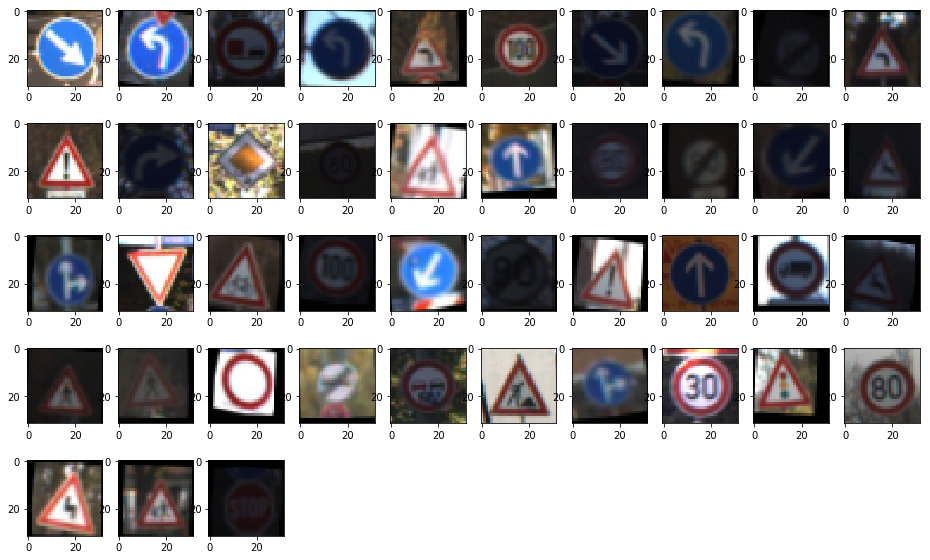

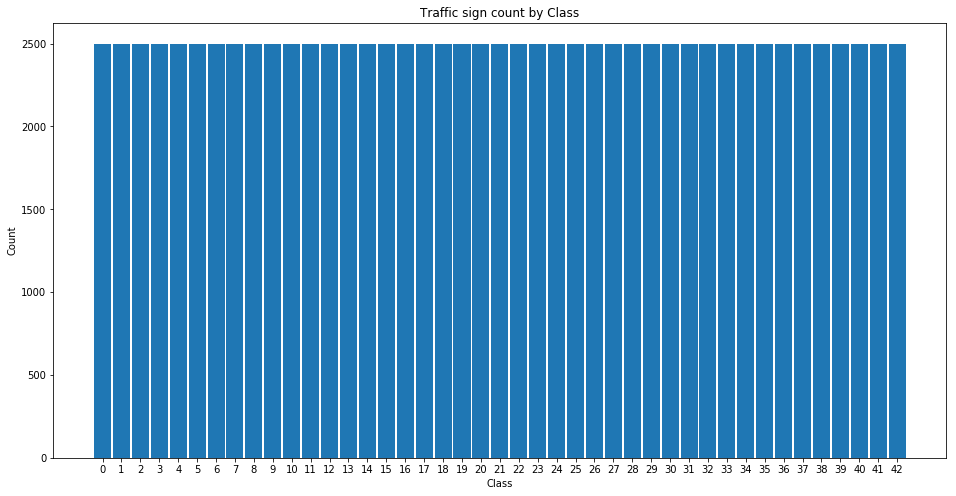

In [6]:
# Plot examples of generated images
fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(10)

for index, sign in enumerate(signs):
    ax = fig.add_subplot(5, 10, index + 1)   
    image = X_train_generated[random.randint(0, len(X_train_generated) - 1)].squeeze()
    ax.imshow(image, cmap='gray')


# Count the occurance of each individual label
labels, count_signs_by_class = zip(*Counter(y_train_generated).items())
indexes = np.arange(len(labels))

# Show bar chart 
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(indexes, count_signs_by_class, width=0.9, align='center')
ax.set_title('Traffic sign count by Class')
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.set_xticks(indexes)
ax.set_xticklabels(labels)
plt.show()

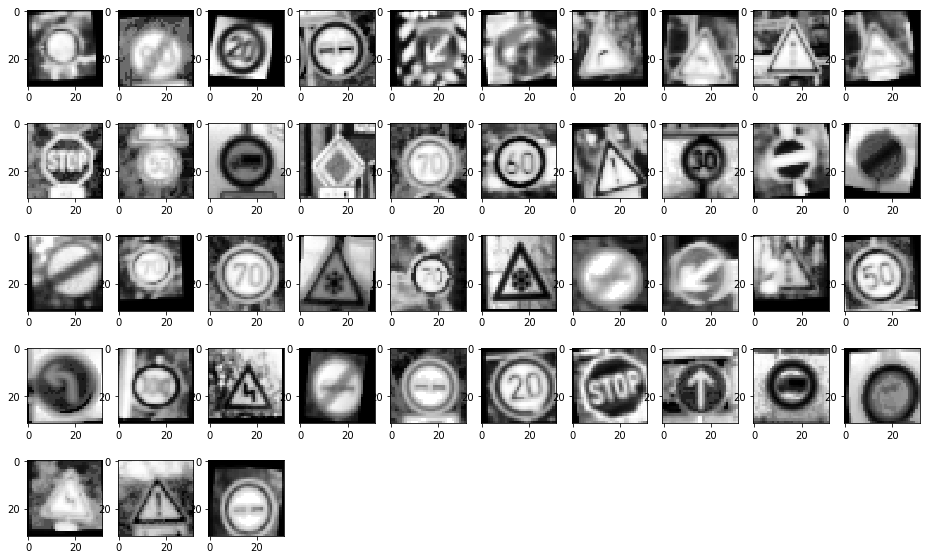

In [7]:
# Preprocess the data
X_train_preprocessed = preprocess(X_train_generated)
X_valid_preprocessed = preprocess(X_valid)
X_test_preprocessed = preprocess(X_test)

# Show a random collection of the preprocessed images
fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(10)

for index, sign in enumerate(signs):
    ax = fig.add_subplot(5, 10, index + 1)   
    image = X_train_preprocessed[random.randint(0, len(X_train_preprocessed) - 1)].squeeze()
    ax.imshow(image, cmap='gray')

### Model Architecture

In [8]:
# Hyperparameters
epochs = 50
batch_size = 100
learning_rate = 0.001
mu = 0
sigma = 0.1

# Data placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

# LAYER 1
layer1_weights = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean=mu, stddev=sigma))
layer1_biases = tf.Variable(tf.zeros(16))
layer1 = tf.nn.conv2d(x, layer1_weights, strides=[1, 1, 1, 1], padding='VALID') + layer1_biases
layer1 = tf.nn.relu(layer1)

layer1 = tf.nn.max_pool(layer1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')


# LAYER 2
layer2_weights = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean=mu, stddev=sigma))
layer2_biases = tf.Variable(tf.zeros(32))
layer2 = tf.nn.conv2d(layer1, layer2_weights, strides=[1, 1, 1, 1], padding='VALID') + layer2_biases
layer2 = tf.nn.relu(layer2)

layer2 = tf.nn.max_pool(layer2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')


# LAYER 3
layer3_weights = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 512), mean=mu, stddev=sigma))
layer3_biases = tf.Variable(tf.zeros(512))
layer3 = tf.nn.conv2d(layer2, layer3_weights, strides=[1, 1, 1, 1], padding='VALID') + layer3_biases
layer3 = tf.nn.relu(layer3)


# Flatten layers
layer1_flat = flatten(layer1)
layer2_flat = flatten(layer2)
layer3_flat = flatten(layer3)
flattened = tf.concat_v2([layer1_flat, layer2_flat, layer3_flat], 1)
flattened_shape = flattened.get_shape().as_list()

flattened = tf.nn.dropout(flattened, keep_prob)


# LAYER 4
layer4_weights = tf.Variable(tf.truncated_normal(shape=(flattened_shape[1], 43), mean=mu, stddev=sigma))
layer4_biases = tf.Variable(tf.zeros(43))
logits = tf.matmul(flattened, layer4_weights) + layer4_biases


labels_predicted = tf.nn.softmax(logits)

one_hot_y = tf.one_hot(y, 43)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation)


correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

print('Model created')

Model created


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [9]:
# Define accuarcy evaluation function
def evaluate(X_data, y_data):
    """Evaluate model."""
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset + batch_size], y_data[offset:offset + batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


# Start the tensorflow session and run the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_preprocessed)

    print("Training...")
    print()
    for i in range(epochs):
        X_train_shuffled, y_train_shuffled = shuffle(X_train_preprocessed, y_train_generated)
        
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train_shuffled[offset:end], y_train_shuffled[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

        validation_accuracy = evaluate(X_valid_preprocessed, y_valid)
        if (i + 1) % 5 == 0:
            print("EPOCH {} ...".format(i + 1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()

    test_accuracy = evaluate(X_test_preprocessed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

    saver.save(sess, './models/lenet')
    print("Model saved")

Training...

EPOCH 5 ...
Validation Accuracy = 0.979

EPOCH 10 ...
Validation Accuracy = 0.974

EPOCH 15 ...
Validation Accuracy = 0.978

EPOCH 20 ...
Validation Accuracy = 0.981

EPOCH 25 ...
Validation Accuracy = 0.980

EPOCH 30 ...
Validation Accuracy = 0.982

EPOCH 35 ...
Validation Accuracy = 0.980

EPOCH 40 ...
Validation Accuracy = 0.981

EPOCH 45 ...
Validation Accuracy = 0.982

EPOCH 50 ...
Validation Accuracy = 0.977

Test Accuracy = 0.962
Model saved


In [ ]:
### Log of model architectures and performance
"""
Obeservations:
    - Color or Grayscale makes almost no difference, -> go with grayscale for better computing performance
    - Histogram equalization adds another 1-2 % accuracy
    - Weight initialization (tesed truncated_normal and xavier) difference is marignal
    - Increasing the convolutional layer1 from 6 to 32 and layer2 from 16 to 64 pushed the accuracy to above 95%
    
    

16.02.2017  - Standard LeNet5 (C6 - C16 - FC120 - FC84 - SM43) 
            - Epochs: 30 | Batchsize: 150 | LearningRate: 0.001 | Initialization: truncated_normal
            - Normalization: no
            - Preprocessing: no
            - Validation Accuracy: 0.892

16.02.2017  - Standard LeNet5 (C6 - C16 - FC120 - FC84 - SM43) 
            - Epochs: 30 | Batchsize: 150 | LearningRate: 0.001 | Initialization: truncated_normal
            - Normalization: (X_train / 255.0) - 0.5
            - Preprocessing: no
            - Validation Accuracy: 0.921

17.02.2017  - Standard LeNet5 (C32 - C64 - FC120 - FC84 - SM43) 
            - Epochs: 30 | Batchsize: 200 | LearningRate: 0.001 | Initialization: truncated_normal
            - Normalization: (X_train / 255.0) - 0.5
            - Preprocessing: grayscale
            - Validation Accuracy: 0.931

18.02.2017  - Standard LeNet5 (C32 - C64 - FC256 - FC84 - SM43) 
            - Epochs: 30 | Batchsize: 200 | LearningRate: 0.001 | Initialization: truncated_normal
            - Normalization: s(X_train / 255.0) - 0.5
            - Preprocessing: grayscale, equalized Histogram
            - Validation Accuracy: 0.957
          

20.02.2017  - Standard LeNet5 (C32 - C64 - FC256 - FC84 - SM43) 
            - Epochs: 30 | Batchsize: 200 | LearningRate: 0.001 | Initialization: truncated_normal
            - Normalization: s(X_train / 255.0) - 0.5
            - Preprocessing: grayscale, equalized Histogram
            - 4 x additional data (rotated, translated)
            - Validation Accuracy: 0.969


22.02.2017  - Standard LeNet5 (C32 - C64 - FC512 - FC84 - SM43) 
            - Epochs: 30 | Batchsize: 100 | LearningRate: 0.001 | Initialization: truncated_normal
            - Normalization: subtract mean, divide by std deviation
            - Preprocessing: grayscale, equalized Histogram
            - 4 x additional data (rotated, translated)
            - Validation Accuracy: 0.973

22.02.2017  - Advanced LeNet5 (C16 - C32 - FC512 - SM43) [connecting both convolution outputs to the FC512]
            - Epochs: 30 | Batchsize: 100 | LearningRate: 0.001 | Initialization: truncated_normal
            - Normalization: (X_train / 255.0) - 0.5
            - Preprocessing: grayscale, equalized Histogram
            - 4 x additional data (rotated, translated)
            - Validation Accuracy: 0.987

"""

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

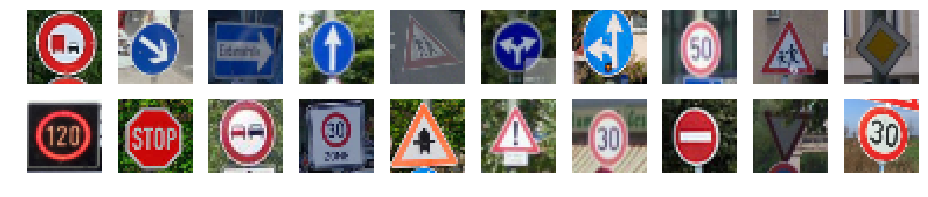

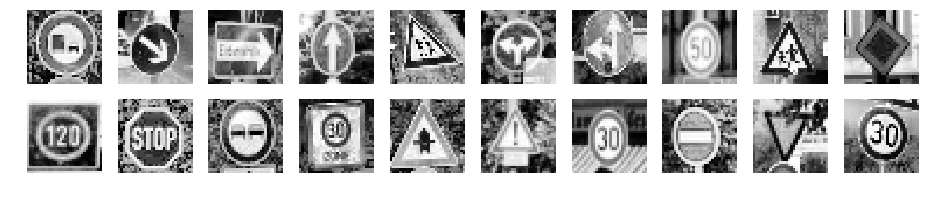

In [10]:
def load_image(name):
    image = cv2.imread(name)
    image = cv2.resize(image,(32,32))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return image

example_images = []
example_labels = []

for img_name in glob.glob('./examples/sign*.png'):
    image = load_image(img_name)
    img_class = re.search('class(.*?).png', img_name).group(1)
    example_images.append(image)
    example_labels.append(int(img_class))
    

# Show original example images
fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(3)

for index, image in enumerate(example_images):
    ax = fig.add_subplot(2, 10, index + 1)
    ax.axis('off')
    ax.imshow(image)


X_new_examples = np.array(example_images)
X_new_examples = preprocess(X_new_examples)


# Show preprocessed example images
fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(3)

for index, image in enumerate(X_new_examples):
    ax = fig.add_subplot(2, 10, index + 1)
    ax.axis('off')
    img = X_new_examples[index].squeeze()
    ax.imshow(img, cmap='gray')

### Predict the Sign Type for Each Image

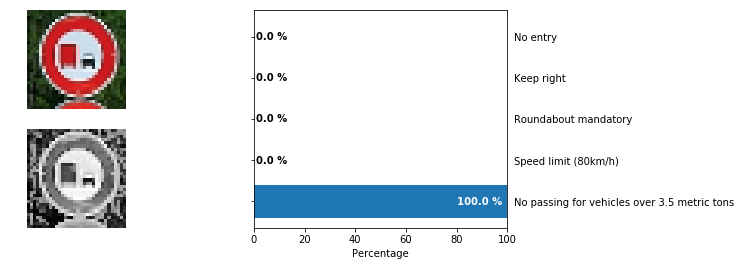

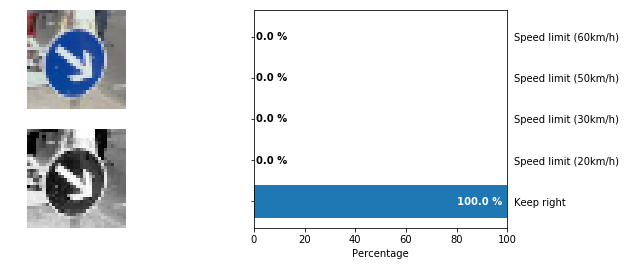

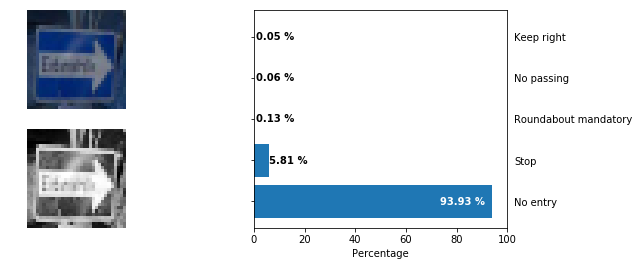

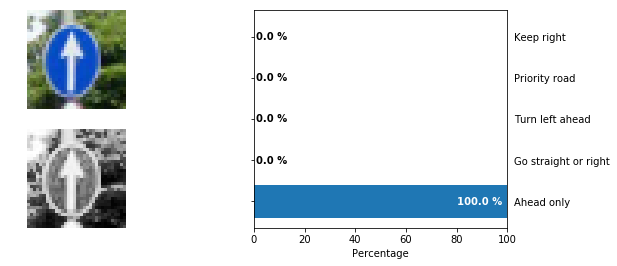

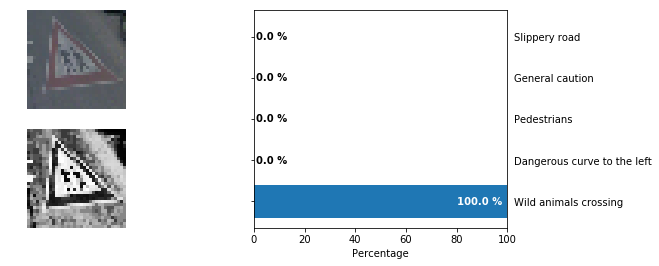

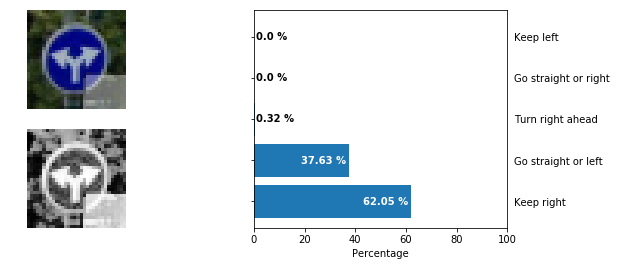

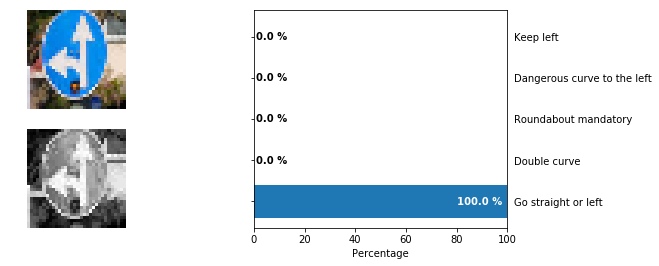

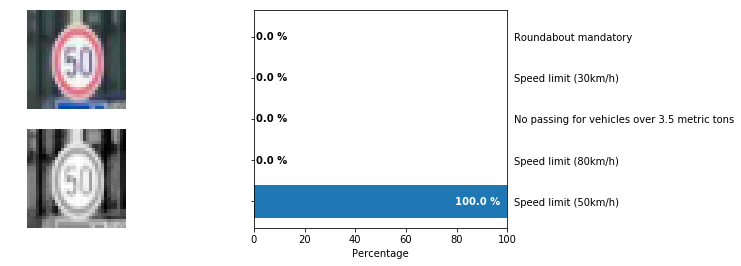

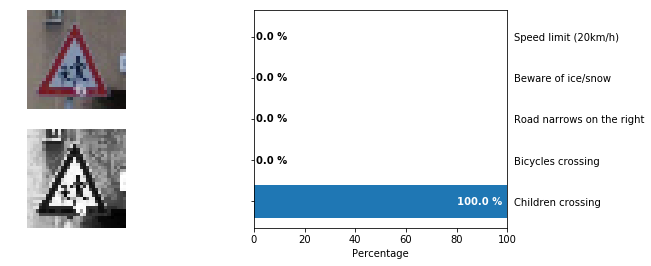

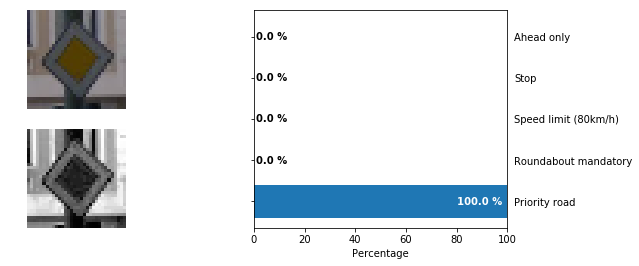

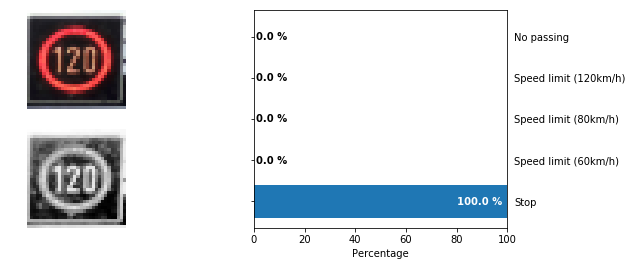

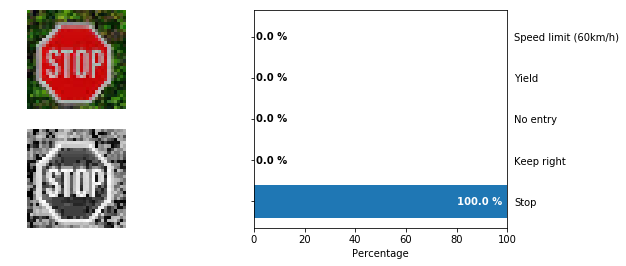

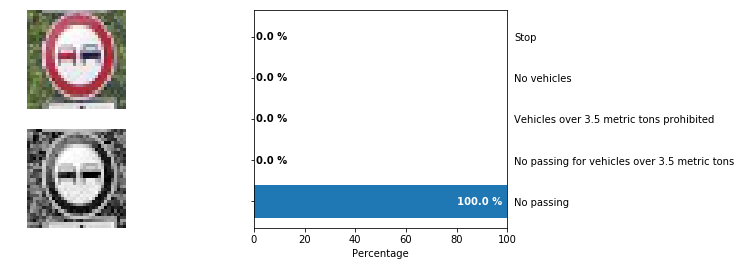

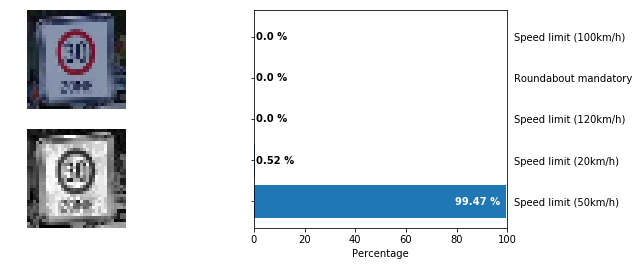

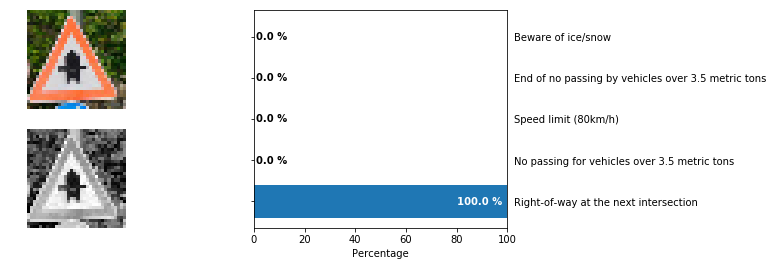

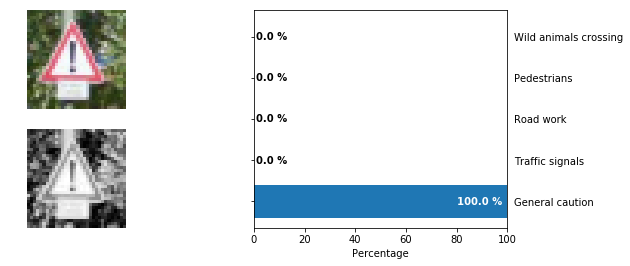

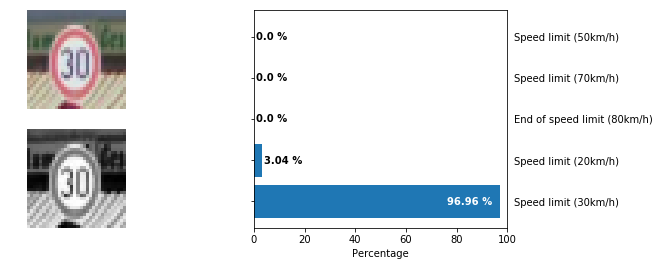

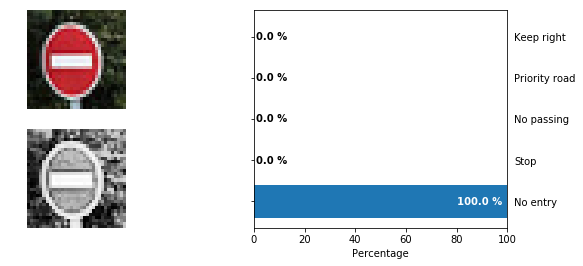

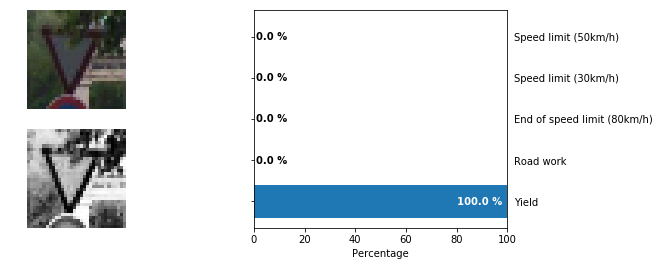

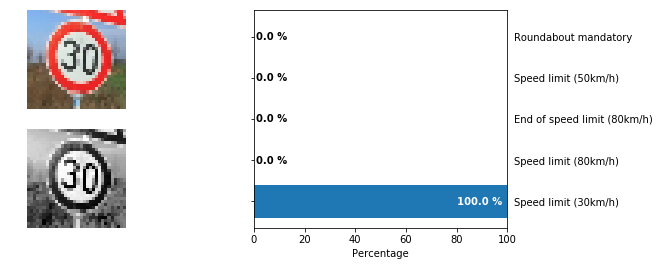

In [11]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, save_path='./models/lenet')
    
    # Calculate the top 5 predictions for each example image
    top_5 = tf.nn.top_k(labels_predicted, 5)
    top_5_predictions = sess.run(top_5, feed_dict={x: X_new_examples, keep_prob: 1.0})
    
    # Show each example image and the corresponding top 5 predictions
    for i in range(len(example_images)):
        # Define grid
        plt.figure(figsize = (10, 4))
        gs = gridspec.GridSpec(2, 2)

        # Show original image
        plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
        plt.imshow(example_images[i])
        plt.axis('off')

        # Show preprocessed image
        plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
        plt.imshow(X_new_examples[i].squeeze(), cmap='gray')
        plt.axis('off')
        
        # Show predictions
        ax = plt.subplot2grid((2, 2), (0, 1), colspan=2, rowspan=2)
        ax.set_xlim([0, 100])
        
        rects = ax.barh(np.arange(5) + 0.5, [value * 100.0 for value in top_5_predictions[0][i]], align='center')
        ax.set_yticks(np.arange(5) + 0.5)
        ax.set_yticklabels(signnames[top_5_predictions[1][i].astype(int)])
        ax.set_xlabel('Percentage')
        plt.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='on')
        
        for index, rect in enumerate(rects):
            width = int(rect.get_width())
            xValue = round(top_5_predictions[0][i][index] * 100.0, 2)
            labelStr = str(xValue) + ' %'
            
            if (width < 25):
                xloc = width + 1
                clr = 'black'
                align = 'left'
            else:
                xloc = 0.98 * width
                clr = 'white'
                align = 'right'
            
            yloc = rect.get_y() + rect.get_height() / 2.0
            ax.text(xloc, yloc, labelStr, horizontalalignment=align, verticalalignment='center', 
                            color=clr, weight='bold', clip_on=True)

        plt.show()



### Analyze Performance

In [12]:
# Calculate accuracy for each example image (excluding signs with no corresponding class)
example_labels = np.array(example_labels)

with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, save_path='./models/lenet')
    
    X_examples = X_new_examples[example_labels < 99]
    y_examples = example_labels[example_labels < 99]
    y_examples = np.eye(n_classes)[y_examples]

    predictions = sess.run(labels_predicted, feed_dict={x: X_examples, keep_prob: 1.0})    
    accuracy = 100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(y_examples, 1)) / predictions.shape[0]
    
    print("Accuracy on example images: %.2f%%" % (accuracy))


Accuracy on example images: 83.33%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [6]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
"""
    Please see section 'Predict the Sign Type for Each Image' for the predictions
"""


> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 